### <center>Universidad Nacional de Tres de Febrero</center>
### <center>Ingeniería de Sonido</center>

### <center>Analisis acústico de recinto</center>

### <center>Juan Martin Fassi</center>




## Primera Parte : Filtros y análisis espectral


El estudio acústico de recintos usualmente requiere de la realización de mediciones in-situ.
Comúnmente, dentro de los recintos se cuenta con un determinado nivel de piso de ruido que
interfiere con las señales acústicas utilizadas para las mediciones. Entonces, es necesario realizar
un análisis previo a la etapa de medición propiamente dicha, en el cual se pueda asegurar que el
nivel de piso de ruido esta lo suficientemente alejado del nivel producido por el sistema utilizado
para la medición.

Se cuenta con tres archivos:

 + noise.wav que corresponde a 5 segundos de grabación de ruido de fondo.
 + source.wav que corresponde a 5 segundos de grabación de la fuente emitiendo ruido
rosa.
 + cal.wav que corresponde a 5 segundos de grabación de la señal del calibrador.

 
El calibrador es un instrumento utilizado para tener una referencia fiable de nivel de presión
sonora. En resumen, el calibrador es un dispositivo que emite un tono de 1 Khz a un nivel de
presión sonora de 1 Pa, es decir, 94 dB SPL.

Importación de Librerias necesarias para el funcionamiento del código

In [1]:
import sys
sys.path.append('modulos')
from main import np, sf, graficar, audio  #optamos por importar todo desde un unico archivo (main.py)


### Desarrollo:

#### Carga de audios y parametros auxiliares

In [2]:
nombre_fuente="audios/mediciones/source.wav"  
source,fs=sf.read(nombre_fuente)    # Carga del Ruido Rosa

cal,fs=sf.read("audios/mediciones/cal.wav")    # Carga de la señal del calibrador

noise,fs=sf.read("audios/mediciones/noise.wav")    # Carga del Ruido de fondo

duracion=len(cal)/fs    
duracion=int(duracion)

# Vector temporal correspondiente a la duración de las señales
t=np.linspace(0,duracion,duracion*fs)  

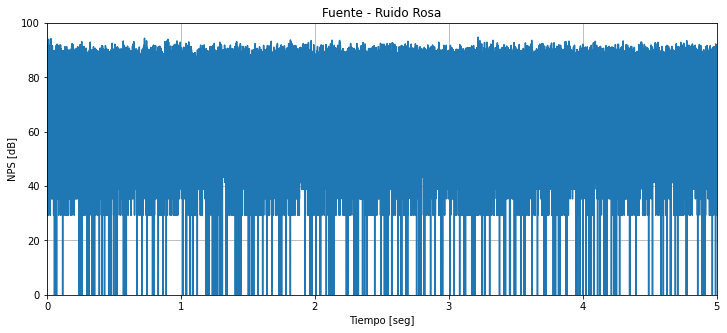

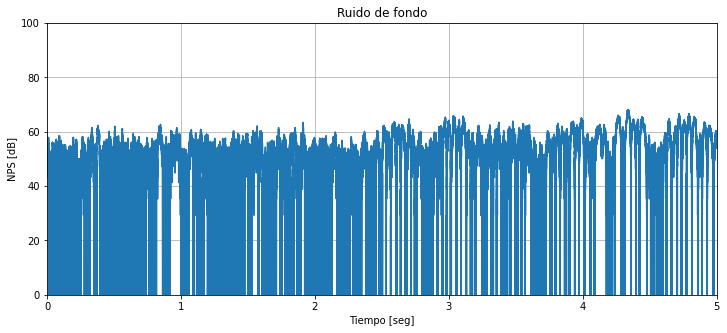

In [3]:
# Conversion de valores de presión [Pa] a SPL [dB] para el Ruido Rosa
source_nps = audio.pa_to_nps(audio.raw_to_pa(source,cal)) 
# Conversion de valores de presión [Pa] a SPL [dB] para el Ruido de fondo
noise_nps = audio.pa_to_nps(audio.raw_to_pa(noise,cal)) 

# Conversion de valores de presión [Pa] a SPL [dB] para el audio del calibrador
cal_nps = audio.pa_to_nps(audio.raw_to_pa(cal,cal))

graficar.señal(t,source_nps,duracion,"Fuente - Ruido Rosa","Tiempo [seg]","NPS [dB]")
graficar.señal(t,noise_nps,duracion,"Ruido de fondo","Tiempo [seg]","NPS [dB]")


Las líneas que se ven son debido a que reemplazamos los ceros de la señal en [Pa] por el minimo valor representable por un float para que no se genere un warning debido a un logaritmo de cero.

A partir de estos valores podemos obtener los NPS equivalentes para cada audio. Esto nos da una idea en que nivel aproximado se efectuaron las mediciones, sin separar por frecuencias.

In [4]:
leq_source = audio.leq(source_nps,fs,duracion)
leq_noise = audio.leq(noise_nps,fs,duracion)
leq_cal = audio.leq(cal_nps,fs,duracion)
print("Ruido rosa: %.2f dB\nRuido ambiente: %.2f dB\nCalibrador: %.2f dB" % (leq_source,leq_noise,leq_cal))

Ruido rosa: 81.81 dB
Ruido ambiente: 55.89 dB
Calibrador: 93.98 dB


### b) Bancos de Filtros

#### Criterios tomados en cuenta:
    
1. Frecuencias centrales:
    Obtenidas a partir de las frecuencias nominales presentes en la norma 61260. Tabla A.1
    <br>
    + Para bandas de octava: 31.25,62.5,125,250,...,16000
    <br>
    + Para bandas de tercio: 25,31.5,40,50,63,...,12.5k,16k,20k

    + Si bien las mediciones fueron tomadas en aulas, en donde las frecuencias altas no son tan relevantes, analizamos todo el espectro aprovechando la capacidad de calculo que tenemos.

2. Anchos de banda:
Se setearon los anchos de banda sucesivos de manera tal que la relación entre frecuencia mayor y frecuencia menor sea igual a 2, en caso de las bandas de octavas, y 2^(1/3) en el caso de las bandas de tercio de octava según indica la norma 61620 en el inciso 3.7 y el 3.10 (pagina 7)

3. Atenuacion en banda de paso: 
la norma 61260 clasifica segun filtros de clase 0,1 y 2 con atenuaciones de +-0.15,+-0.3 y +-0.5 respectivamente para la banda de paso. Tabla 1. (Pagina 11).

4. Atenuacion mínima y máxima: 
La norma exige un mínimo de (20-16.5)dB/oct, según la clase del filtro, y un máximo de inf dB/oct. Esto nos entraga un orden mínimo de filtro mayor o igual a 3. Tabla 1. (Pagina 11).

5. Relación señal / ruido: 
La norma 3382 exige que la fuente debería ser capaz de producir un NPS por encima de los 35dB respecto del ruido de fondo. Si lo que se va a medir es el T30 se necesitan alrededor de 45dB. Concluimos entonces que la medición será completamente fiable cuando se superen los 45dB de relacion señal/ruido. 

    "The source shall be able to produce a sound pressure level sufficient to
    ensure a decay curve starting at least 35 dB above the background noise in the corresponding frequency band. If T30 is to be measured, it is necessary to create a level at least 45 dB above the background level" (pagina 5).

6. Tipo de filtro y parámetros:
Se eligió un filtro de tipo Buttersworth de orden 4 por defecto pero puede modificarse. Este tipo de filtros es el que mas se acerca el filtro ideal y el mas estable en la banda de paso y de transición, además posee una atenuación importante. Con esto logramos que la atenuación en la banda de paso sea de alrededor de 0dB y con una atenuación mayor a 6dB/oct.

### Filtros por banda de octava

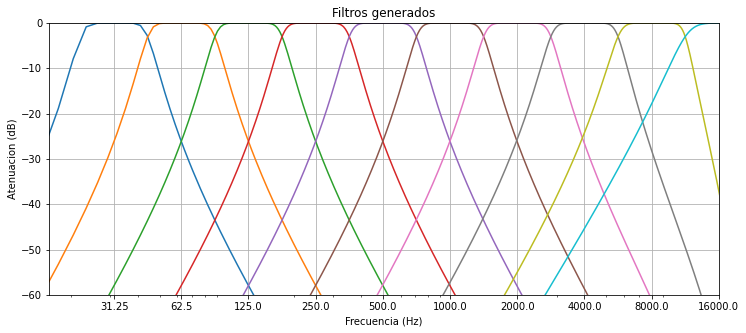

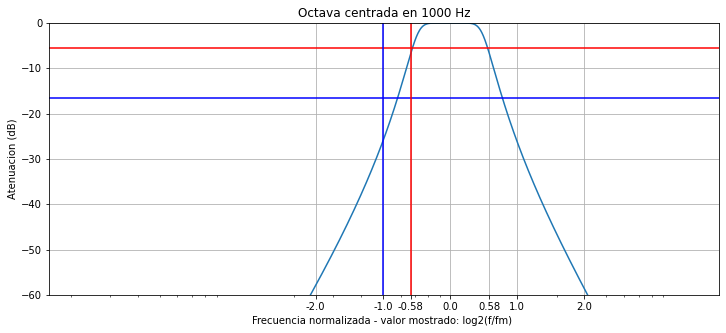

Frencuencia central: 1000.0 Hz
Frecuencias de corte: 707.1 Hz - 1414.2 Hz
Ancho de banda: 707.1 Hz
Relacion f_superior/f_inferior: 2.0000000000000004


In [5]:
#Conversion a Pa
source_pa = audio.raw_to_pa(source,cal)

#Generacion de bandas ya filtradas
octavas_filtradas_pa , freqs = audio.filtro_norma(fs,source_pa,visualizar_data=True)

La línea azul vertical indica una octava desde la frecuencia central y la azul horizontal indica el minimo de 16.5dB de atenueación. Vemos que estamos por debajo de ese valor, cumpliendo con la norma.

La línea roja vertical indica la mitad de una octava y la linea roja horizontal indica un maximo de 4.5dB de atenuación. Vemos que el filtro esta por encima de ese valor, cumpliendo tambien con la norma.

Eligimos así a un filtro de clase 2 según la tabla 1 de la norma. Los valores mostrados de el eje x fueron elegidos para comparar con los valores de dicha tabla.

Por otro lado, se observa una relacion entre la frecuencia superior y la frecuencia inferior exactamente igual a 2.

### c) Filtrado de las señales

### Análisis de Fuente - Ruido Rosa por bandas de octava

#### Espectro de Frecuencias y Filtrado

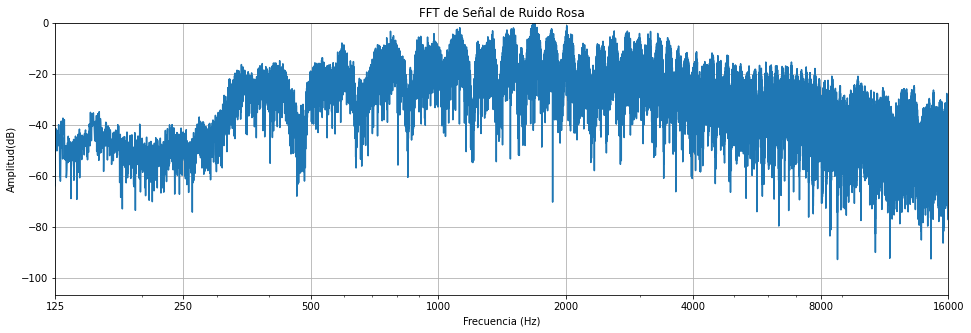

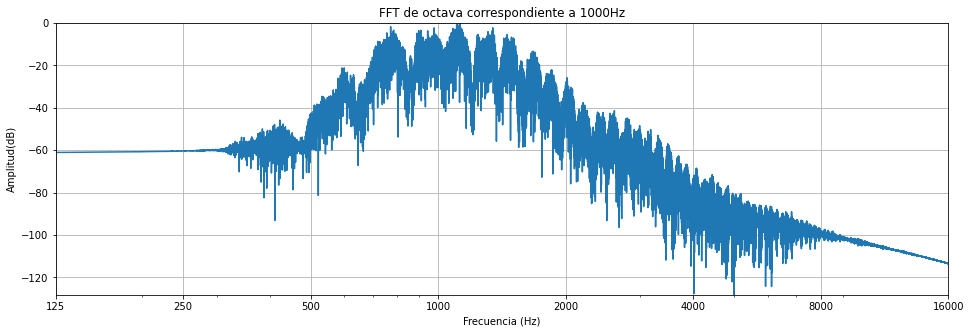

In [6]:
# Se obtiene la Respuesta en Frecuencia de la Senal de Ruido Rosa
graficar.fft(np.fft.fft(source_pa),125,16000,fs,"FFT de Señal de Ruido Rosa",dB=True)
# Se elige la banda que se de sea dejar pasar y se filtra la señal
octava_pa=octavas_filtradas_pa[5]
graficar.fft(np.fft.fft(octava_pa),125,16000,fs,"FFT de octava correspondiente a 1000Hz",dB=True)

Del último grafico puede verse que el filtro está, efectivamente, atenuando fuera de la banda de paso.

#### Obtención del Nivel de Presión Equivalente  (Leq)


BANDA      NPS
31.25     50.36
62.50     45.83
125.00     38.01
250.00     52.44
500.00     65.62
1000.00     75.35
2000.00     78.51
4000.00     75.83
8000.00     67.61
16000.00     59.16


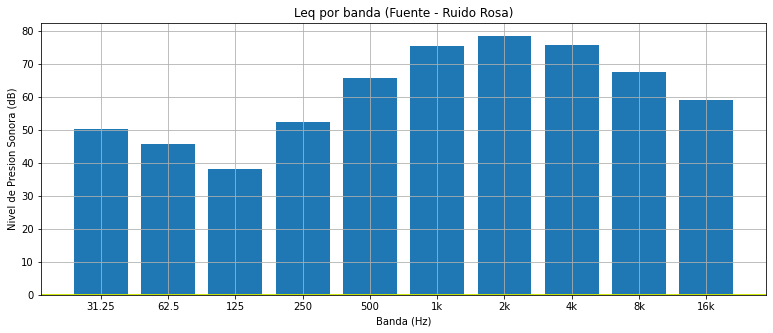

In [7]:
# Obtención de nivel de presion NPS para cada banda
octavas_filtradas_nps=audio.bandas_pa_to_nps(octavas_filtradas_pa)
# Cálculo de Leq para cada banda
leq_por_banda=audio.bandas_a_leq(octavas_filtradas_nps,fs,duracion)

print("BANDA      NPS")

i=0
for i in range(0,10):
    print("%.2f     %.2f" % (freqs[i],leq_por_banda[i]))
graficar.bandas_db(leq_por_banda,"Leq por banda (Fuente - Ruido Rosa)")

Se puede observar que el ruido rosa tiene un bajo contenido espectral en la zona de las frecuencias graves por debajo de los 250Hz respecto de lo que se esperaria de un ruido rosa convencional, sin pasar por ningun sistema. Esto se puede deber a la distancia entre la fuente y el micrófono o simplemente por caracteristicas del recinto donde se tomaron las mediciones.

### Análisis de Ruido de fondo por bandas de octava

#### Obtención del Nivel de Presión Equivalente por banda (Leq)



BANDA      NPS
31.25     42.81
62.50     38.46
125.00     40.01
250.00     39.02
500.00     28.50
1000.00     20.44
2000.00     21.30
4000.00     19.12
8000.00     20.74
16000.00     34.08


<Figure size 864x360 with 0 Axes>

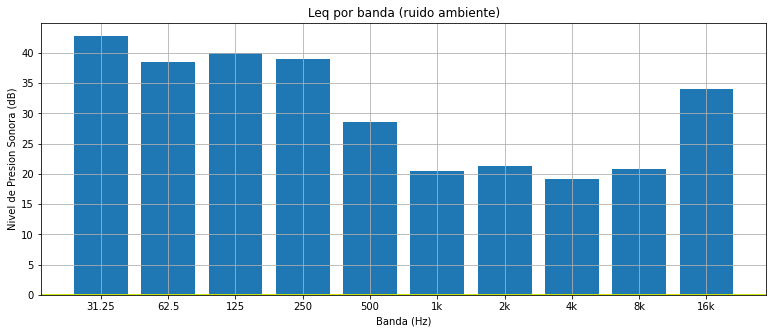

In [9]:

# Cambio de unidades a [Pa]
source_ruido_pa=audio.raw_to_pa(noise,cal)
# Filtrado por bandas en [Pa]
octavas_filtradas_ruido_pa , freqs= audio.filtro_norma(fs,source_ruido_pa)
# obtención de NPS de bandas filtradas
octavas_filtradas_nps_ruido=audio.bandas_pa_to_nps(octavas_filtradas_ruido_pa)
# Obtención de Leq por banda
leq_por_banda_ruido=audio.bandas_a_leq(octavas_filtradas_nps_ruido,fs,duracion)


print("BANDA      NPS")
i=0
for i in range(0,10):
    print("%.2f     %.2f" % (freqs[i],leq_por_banda_ruido[i]))
graficar.bandas_db(leq_por_banda_ruido,"Leq por banda (ruido ambiente)")



Se puede apreciar que el ruido ambiente tiene un mayor incidencia en frecuencias por debajo de los 250Hz. 

###   Obtencion de la relacion señal ruido 

Se realizo una resta entre los valores del Leq por banda del ruido rosa y del ruido ambiente para comparar los niveles relativos entre estos.

BANDA      NPS
31.25     7.55
62.50     7.36
125.00     -2.00
250.00     13.42
500.00     37.12
1000.00     54.90
2000.00     57.21
4000.00     56.71
8000.00     46.87
16000.00     25.09


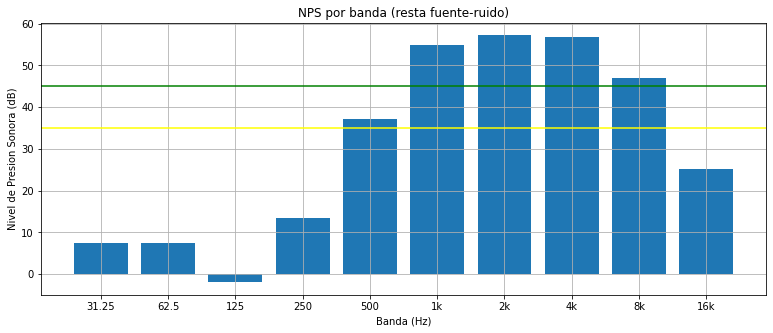

In [10]:
# Relación entre el Leq del Ruido Rosa con el de la señal del Ruido de fondo
leq_por_banda_resta=leq_por_banda-leq_por_banda_ruido

print("BANDA      NPS")
i=0
for i in range(0,10):
    print("%.2f     %.2f" % (freqs[i],leq_por_banda_resta[i]))
    
graficar.bandas_db(leq_por_banda_resta,"NPS por banda (resta fuente-ruido)",axhline=[45,35])

Las líneas verdes y amarillas representan el piso de 45dB y 35 dB de relación señal ruido respectivamente. Hasta este punto podemos ofrecer un intervalo de confianza de entre 1k y 8k junto con la banda de 500Hz que supera levemente los 35dB mínimos requeridos.  En este rango, las mediciones de parametros acústicos serán confiables.

### Filtrado por tercios de octava

+ Se realiza el mismo analisis pero por tercios de octava.

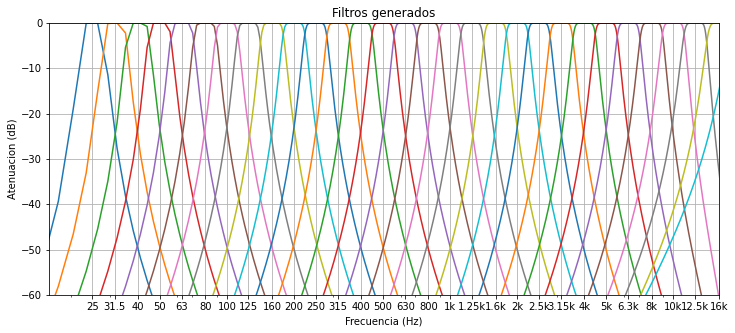

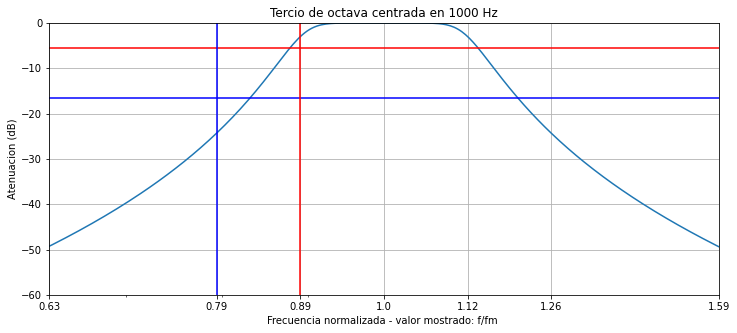

Frencuencia central: 1000.0 Hz
Frecuencias de corte: 890.9 Hz - 1122.5 Hz
Ancho de banda: 231.6 Hz
Relacion f_superior/f_inferior: 1.2599210498948734
2^(1/3)= 1.2599210498948732


In [11]:
octavas_filtradas_pa , freqs = audio.filtro_norma(fs,source_pa,visualizar_data=True,octava=3)
print("2^(1/3)=",2**(1/3))

Otra vez se cumple que la relación entre anchos de banda sucesivos es de 2^(1/c) donde c es la fracción de octava. En este caso c=3.

Puede verse una disminución de la resolución de los filtros generados en frecuencias bajas (menores que 125 Hz). Para los fines del trabajo práctico, no resulta un problema puesto que en frecuencias bajas la relacion entre señal ruido es cercana a 0dB, lo que implica que no seria conveniente utilizar esos valores para calcular parámetros acústicos.

La línea azul vertical indica un tercio de octava desde la frecuencia central y la azul horizontal indica el mínimo de 16.5dB, vemos que estamos por debajo de ese valor, cumpliendo con la norma.

La línea roja vertical indica la mitad de un tercio de octava y la línea roja horizontal indica el maximo de 4.5dB de atenuación. Vemos que el filtro esta por encima de ese valor, cumpliendo también con la norma.

### Análisis por tercio de octava del Ruido Rosa

#### Obtención del Nivel de Presión Equivalente  (Leq)

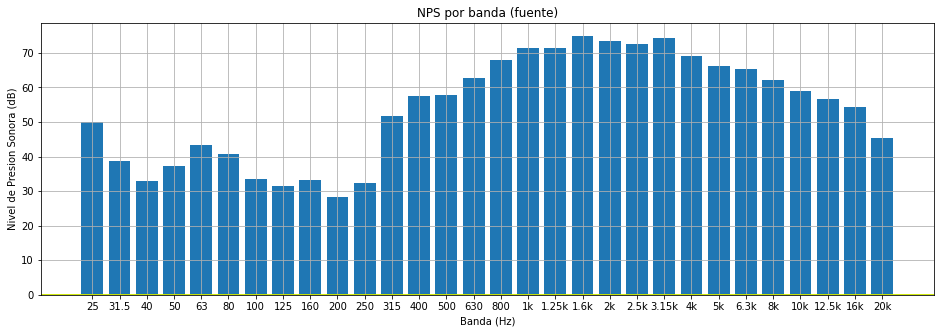

In [12]:
# Obtencion de NPS por banda
octavas_filtradas_nps=audio.bandas_pa_to_nps(octavas_filtradas_pa)
# Obtención de Leq por banda
leq_por_banda=audio.bandas_a_leq(octavas_filtradas_nps,fs,duracion,fraccion_octava=3)

graficar.bandas_db(leq_por_banda,"NPS por banda (fuente)",octava=3)


### Análisis por tercio de octava para el ruido de fondo

#### Obtención del Nivel de Presión Equivalente  (Leq)

<Figure size 864x360 with 0 Axes>

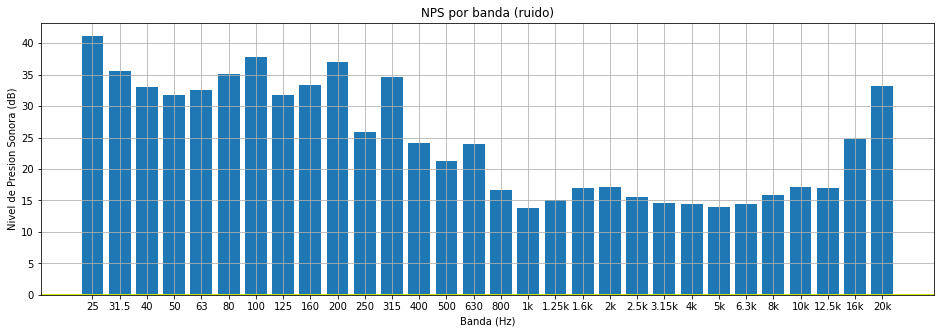

In [13]:
# Filtrado por tercio de octava en banda deseada
octavas_filtradas_pa_ruido , freqs = audio.filtro_norma(fs,source_ruido_pa,visualizar_data=False,octava=3)
# Obtencion de NPS por banda
octavas_filtradas_nps_ruido=audio.bandas_pa_to_nps(octavas_filtradas_pa_ruido)
# Obtencion de Leq por banda
leq_por_banda_ruido=audio.bandas_a_leq(octavas_filtradas_nps_ruido,fs,duracion,fraccion_octava=3)

graficar.bandas_db(leq_por_banda_ruido,"NPS por banda (ruido)",octava=3)

###   Obtencion de la relacion señal ruido (por tercio de octava)
Nuevamente se realiza una resta entre ambas señales para obtener la relacion señal ruido por banda de tercio de octava.

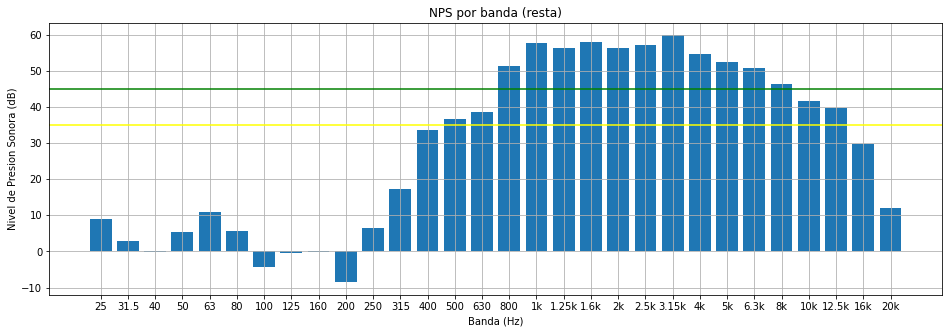

In [14]:
# Relación entre el Leq del Ruido Rosa con el de la señal del Ruido de fondo
leq_por_banda_resta=leq_por_banda-leq_por_banda_ruido
graficar.bandas_db(leq_por_banda_resta,"NPS por banda (resta)",octava=3,axhline=[45,35])

Nuevamente, las líneas verde y amarrilla indican 45dB y 35dB de relación señal ruido. De este último gráfico vemos que se puede extender el intervalo de confianza hacia (800-8k)Hz. Con las bandas de 500,630,10k y 12.5k cumpliendo con el mínimo de 35dB.Por otro lado, la banda de 200 Hz muestra un nivel negativo , lo que implica que el ruido de la sala es mayor al ruido rosa, esto de puede deber a una resonancia al momento de captar el ruido, o incluso al aporte de una fuente externa de la sala.

## Conclusiones

En un principio entonces tendremos una medición fiable y precisa para calcular parámetros acústicos dentro del rango entre 800 y 8000Hz. Sin embargo, teniendo en cuenta:

+ Que las mediciones fueron hechas en aulas de universidad, en donde las frecuencias que mas van a estar excitando el reciento serán las correspondientes al habla. 

+ Que las frecuencias fundamentales para la voz humana oscilan entre los 85Hz y 300Hz y sus armónicos pueden llegar hasta los 3400Hz.

Consideramos que habrá información respecto a la voz humana en las aulas que no se verán descriptas mediante los parámetros acústicos que se calcularán. Es decir, las mediciones tomadas son fiables para un cierto rango de frecuencias, pero creemos que si existe la posibilidad de repetirlas, se podría llegar a mejores resultados aumentando el NPS que entrega la fuente o realizando las mediciones en un momento del dia en donde el ruido de fondo sea menor.

